# E-Commerce RFM Classification and Predictive Model: 


**Problem Statement:**

In order to develop a consumer focused market strategy, how can our client’s customer data be categorized for forecasting what they will purchase over the next year using an RFM categorization strategy?

**Context:**

Our client is a UK-based retailer that primarily sells unique all-occasion gifts. Many customers of the retailer are wholesalers. Our client has provided the previous year’s (01/12/2010 - 09/12/2011) transaction history of its customers. The client wants a model which identifies customers based on recency, frequency and monetary value for targeted marketing strategies such as reward programs, VIP memberships, and mailing lists. All of  this will allow our client to focus on customer retention across the entire customer base.

**Criteria for success:**

The model most properly categorize:
- the recency of customers (time between purchases);
- the frequency of a customer’s purchase history;
- the monetary value of a customer (how much they spend);
- and accurately categorize future customers.

**Scope of solution space:**

Focus will be on the past year’s transactional history for all customers provided by the client. After identifying key features of the data, a model can be developed based on the key features that properly categorizes the customers.

**Constraints within solution space:**

- Customers that have no ID (likely customers that purchased as a guest) will need to be dropped as they cannot be consistently measured.
- Customers that are other large retail companies will likely be outliers.
- The model will be based on the recent trends and cannot accurately measure developing trends for the next year (think fidget spinners and pop culture).

**Stakeholders to provide key insight:**

Our largest stakeholders are our client’s:
- CEO
- Head of Marketing
- Marketing Strategist
- PR department
- Highest RFM customers 

**Key data sources:**

The past years transaction data provided in the csv file labeled “data.csv.”


## Part 1 - Data Wrangling

In [1]:
# Here we go, let's import the basics of what we expect we will be nedding to complete this notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.metrics
import matplotlib.cm as cm
import sklearn.decomposition
import matplotlib.colors

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('data.csv')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Alright, so lets first start cleaning the data.

In [2]:
# My good friend and fellow Data Scientist Ben Merrill wrote this function to look for nan values. 
# I always use it now for a clean, easy to read output about missing values in the data. 
# Go check his Github out!

def show_na(df):
    na_df = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    na_df.columns=['count', '%']
    na_df.sort_values(by='count', ascending = False)
    return na_df
# Use the function
show_na(data)

,count,%
InvoiceNo,0,0.000000
StockCode,0,0.000000
Description,1454,0.268311
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
CustomerID,135080,24.926694
Country,0,0.000000


Hmm... entry's missing descriptions will be less useful to our client. Entry's missing CustomerID are actually going to be useless as there's no way to record that customers Recency and Frequency. They are probably customers that used our client's store as a guest and didn't create an account. Their monetary value could be useful in categorizing what the average monetary value of guest customers would be, but it would probably be rather inaccurate as this could vary quite a bit.



In [3]:
# Let's drop the missing CustomerID entries. We can always do something with it later if the client is interested in it.
data = data.loc[(data.CustomerID.isnull()==False)]
show_na(data)

,count,%
InvoiceNo,0,0.0
StockCode,0,0.0
Description,0,0.0
Quantity,0,0.0
InvoiceDate,0,0.0
UnitPrice,0,0.0
CustomerID,0,0.0
Country,0,0.0


Hey, check that out, dropping all of the empty entries for CustomerID got rid of our empty Description entries. We didn't want them anyways.

In [4]:
# Let's examine the stats of the data now that there aren't any nans
data.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Negative Quantity? It matches the maximum quantity, so maybe it is an error. Also, majority of the UnitPrice is under $4(BP) but there are some serious outliers. 

Also, I doubt the client sells anything for $0.00, so that might be an error as well.

Perhaps these are returns. Regardless, they will not be useful in classifying RFM.

In [5]:
data = data[data.Quantity > 0] ## remove negative value in Quantity column
data = data[data.UnitPrice > 0] ## remove negative value in UnitPrice column
data.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [6]:
# Lets create a revenue column just for visualizations
data['Revenue'] = data['Quantity'] * data['UnitPrice']

In [7]:
show_na(data)

,count,%
InvoiceNo,0,0.0
StockCode,0,0.0
Description,0,0.0
Quantity,0,0.0
InvoiceDate,0,0.0
UnitPrice,0,0.0
CustomerID,0,0.0
Country,0,0.0
Revenue,0,0.0


This is good enough for now. As I explore the data, if other issues are discovered I will return here to clean them and ammend the data wrangling section!

**Edit:**
Didn't take long to discover some empty strings. Lets clean those out here.

In [8]:
data.loc[data.Description.isnull()==False, "empty_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"].apply(lambda l: l.lower())

data.empty_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)).value_counts()

False    397287
True        597
Name: empty_descriptions, dtype: int64

In [9]:
data.empty_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)).value_counts()

False    397884
Name: empty_descriptions, dtype: int64

In [10]:
data = data.drop(['empty_descriptions'], axis=1)

show_na(data)

,count,%
InvoiceNo,0,0.0
StockCode,0,0.0
Description,0,0.0
Quantity,0,0.0
InvoiceDate,0,0.0
UnitPrice,0,0.0
CustomerID,0,0.0
Country,0,0.0
Revenue,0,0.0


## Part 2: EDA

Alright, lets take a minute to just explore the data and let it start telling us it's story. The point here is to get an idea of how weighted various features may be, which will provide an indication as to how useful that feature will be in developing the RFM model as well as a predictive model.

In [11]:
# make sure the InvoiceDate column is in datetime format 
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [12]:
# Timeframe of data?
data['InvoiceDate'].max() - data['InvoiceDate'].min()

Timedelta('373 days 04:24:00')

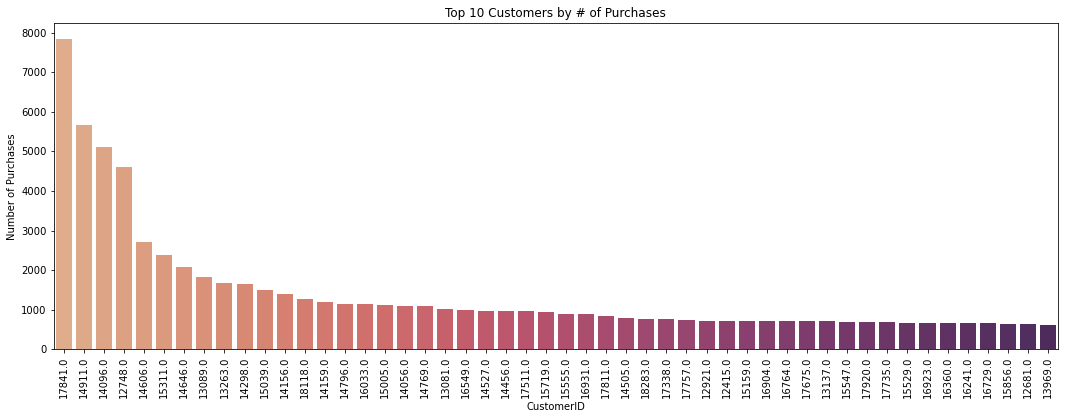

In [13]:
#  Most frequent customers?

customer_count = data['CustomerID'].value_counts().sort_values(ascending=False).iloc[0:50]
plt.figure(figsize=(18,6))
sns.barplot(customer_count.index, customer_count.values, order=customer_count.index, palette="flare")
plt.ylabel("Number of Purchases")
plt.xlabel("CustomerID")
plt.title("Top 10 Customers by # of Purchases")
plt.xticks(rotation=90);

Wow, okay, Customer 17841 has made nearly 8,000 purchases!

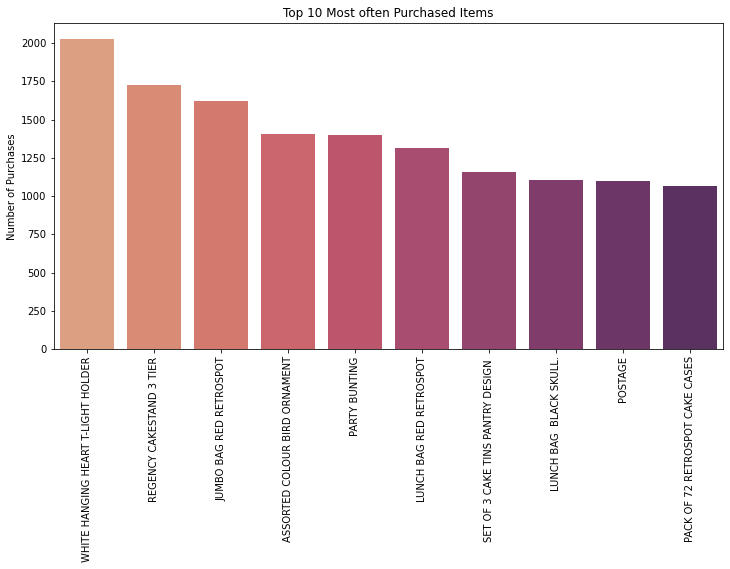

In [14]:
item_counts = data['Description'].value_counts().sort_values(ascending=False).iloc[0:10]
plt.figure(figsize=(12,6))
sns.barplot(item_counts.index, item_counts.values, palette="flare")
plt.ylabel("Number of Purchases")
plt.title("Top 10 Most often Purchased Items");
plt.xticks(rotation=90);

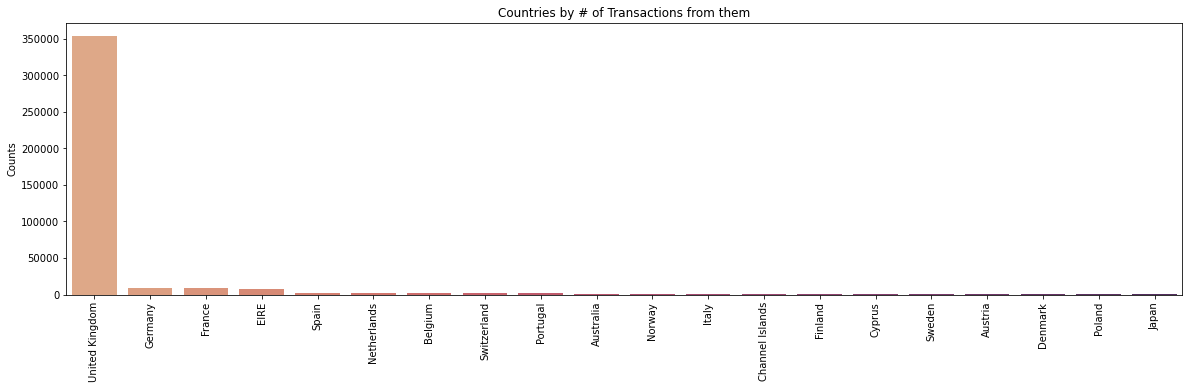

In [15]:
# Let's see if the Dountry column is going to be of use or heavily biased
country_counts = data.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values, palette="flare")
plt.ylabel("Counts")
plt.title("Countries by # of Transactions from them");
plt.xticks(rotation=90);


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 [Text(0, 0, 'Germany'),
  Text(1, 0, 'France'),
  Text(2, 0, 'EIRE'),
  Text(3, 0, 'Spain'),
  Text(4, 0, 'Netherlands'),
  Text(5, 0, 'Belgium'),
  Text(6, 0, 'Switzerland'),
  Text(7, 0, 'Portugal'),
  Text(8, 0, 'Australia'),
  Text(9, 0, 'Norway'),
  Text(10, 0, 'Italy'),
  Text(11, 0, 'Channel Islands'),
  Text(12, 0, 'Finland'),
  Text(13, 0, 'Cyprus'),
  Text(14, 0, 'Sweden'),
  Text(15, 0, 'Austria'),
  Text(16, 0, 'Denmark'),
  Text(17, 0, 'Poland'),
  Text(18, 0, 'Japan'),
  Text(19, 0, 'Israel'),
  Text(20, 0, 'Unspecified'),
  Text(21, 0, 'Singapore'),
  Text(22, 0, 'Iceland'),
  Text(23, 0, 'USA'),
  Text(24, 0, 'Canada'),
  Text(25, 0, 'Greece'),
  Text(26, 0, 'Malta'),
  Text(27, 0, 'United Arab Emirates'),
  Text(28, 0, 'European Community'),
  Text(29, 0, 'RSA'),
  Text(30, 0, 'Lebanon'),
  Text(31, 0

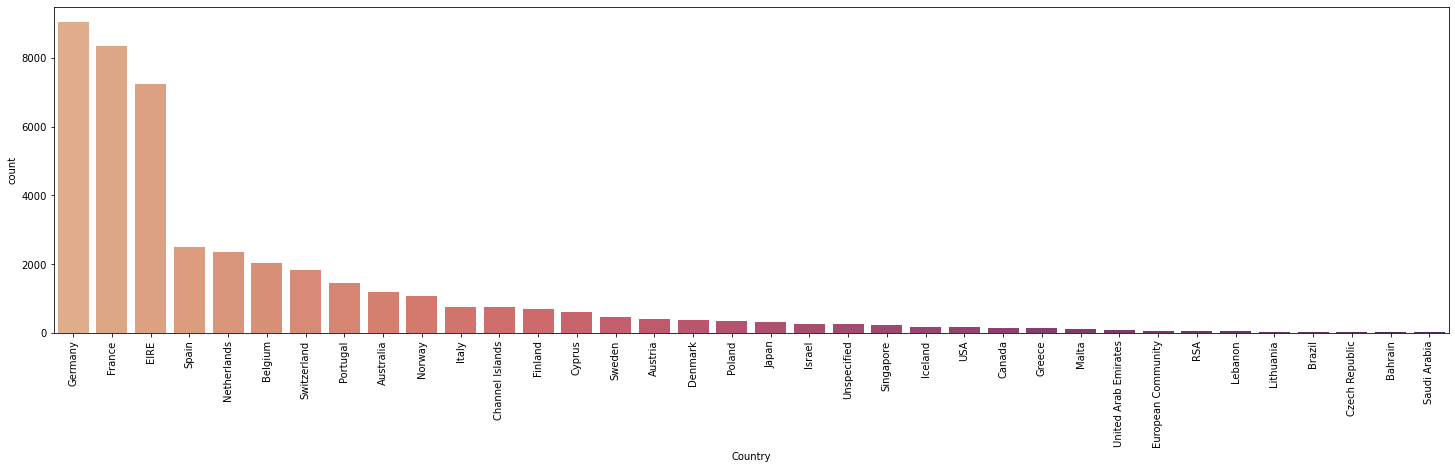

In [16]:
notUK = data[data['Country'] != 'United Kingdom']['Country']
plt.figure(figsize=(25,6))
sns.countplot(notUK, order = notUK.value_counts().index, palette="flare")
plt.xticks(rotation=90)

Yep, we won't be able to generate much information for customers outside of the UK. Might drop them, but we can come back to it later.

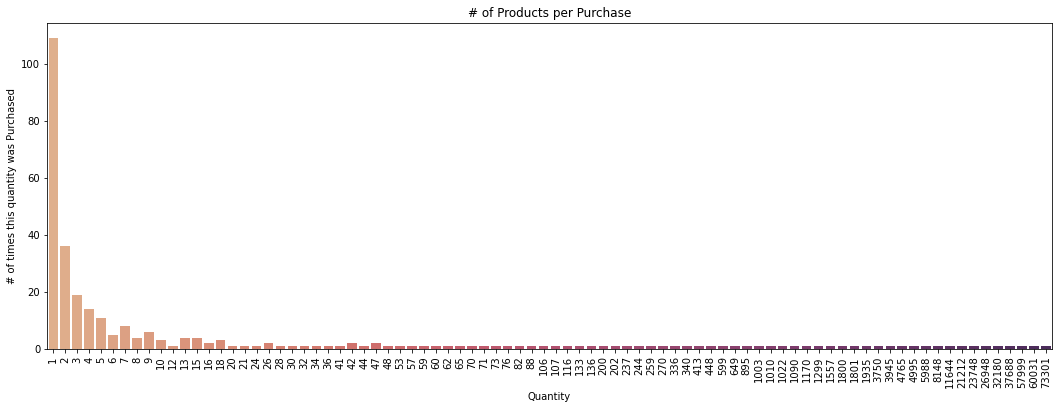

In [17]:
# Lets check out the varying amount of Quantity within purchases. As in, the amount of products within each purchase.
quantity_counts = data.Quantity.value_counts().sort_values(ascending=False)
plt.figure(figsize=(18,6))
sns.countplot(quantity_counts, palette="flare")
plt.ylabel("# of times this quantity was Purchased")
plt.title("# of Products per Purchase");
plt.xticks(rotation=90);

In [18]:
data['Quantity'].quantile([.50,.75,.90,.990,.995,.999])

0.500      6.0
0.750     12.0
0.900     24.0
0.990    120.0
0.995    200.0
0.999    504.0
Name: Quantity, dtype: float64

<AxesSubplot:xlabel='Quantity'>

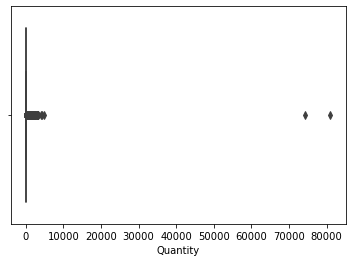

In [19]:
sns.boxplot(data['Quantity'])

Yikes, thats some brutal outliers. Between the graph and the statistics provided with .describe(), it seems that any quantity above 26 is going to be pretty far out from the majority of our data.

In [20]:
data.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,Quantity,UnitPrice,CustomerID,Revenue
0.050,1.0,0.4200,12627.0,1.25
0.950,36.0,8.5000,17912.0,67.50
0.980,96.0,12.7500,18119.0,136.00
0.990,120.0,14.9500,18211.0,202.50
0.999,504.0,41.8904,18283.0,876.00


In [21]:
data = data.loc[data.UnitPrice <= 14.95].copy()
data = data.loc[data.Quantity <= 120.0].copy()
data = data.loc[data.CustomerID <= 18211.0].copy()
data = data.loc[data.Revenue <= 202.50].copy()
data.count()

InvoiceNo      384624
StockCode      384624
Description    384624
Quantity       384624
InvoiceDate    384624
UnitPrice      384624
CustomerID     384624
Country        384624
Revenue        384624
dtype: int64

In [22]:
data.describe()

,Quantity,UnitPrice,CustomerID,Revenue
count,384624.000000,384624.000000,384624.000000,384624.000000
mean,9.652864,2.715603,15273.476692,16.457654
std,13.976852,2.534416,1690.941827,21.953529
min,1.000000,0.001000,12347.000000,0.001000
25%,2.000000,1.250000,13969.000000,4.350000
50%,5.000000,1.850000,15147.000000,10.500000
75%,12.000000,3.750000,16767.000000,17.900000
max,120.000000,14.950000,18211.000000,202.500000


In [23]:
show_na(data)

,count,%
InvoiceNo,0,0.0
StockCode,0,0.0
Description,0,0.0
Quantity,0,0.0
InvoiceDate,0,0.0
UnitPrice,0,0.0
CustomerID,0,0.0
Country,0,0.0
Revenue,0,0.0


<AxesSubplot:xlabel='Quantity'>

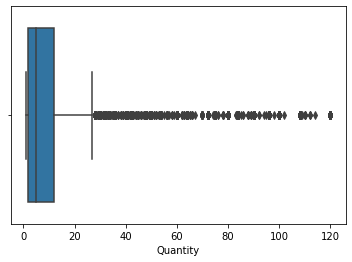

In [24]:
sns.boxplot(data['Quantity'])

## Part 2.5: RFM EDA
The first step is to create the foundations for a cohort analysis do we can start measuring Recency, Frequency, and overall Monetary Value per customer.

In [25]:
# define get_month(x)
def get_month(x):  return dt.datetime(x.year, x.month, 1)

data['InvoiceMonth'] = data['InvoiceDate'].apply(get_month)

grouping = data.groupby('CustomerID')['InvoiceMonth']

data['CohortMonth'] = grouping.transform('min')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01


In [26]:
# define get_date_int function
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [27]:
# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, _ = get_date_int(data, 'InvoiceMonth')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, _ = get_date_int(data, 'CohortMonth')

In [28]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

In [29]:
# Extract the difference in days from all previous values
data['CohortIndex'] = years_diff * 12 + months_diff + 1
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1


In [30]:
grouping = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

In [31]:
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,848.0,309.0,269.0,320.0,307.0,338.0,307.0,289.0,298.0,331.0,315.0,430.0,216.0
2011-01-01,407.0,88.0,112.0,89.0,129.0,116.0,101.0,97.0,123.0,133.0,148.0,47.0,NaN
2011-02-01,369.0,65.0,69.0,101.0,100.0,92.0,90.0,99.0,93.0,115.0,26.0,NaN,NaN
2011-03-01,446.0,66.0,111.0,92.0,102.0,76.0,119.0,105.0,123.0,37.0,NaN,NaN,NaN
2011-04-01,289.0,63.0,60.0,57.0,53.0,68.0,64.0,74.0,21.0,NaN,NaN,NaN,NaN
2011-05-01,272.0,52.0,44.0,46.0,55.0,60.0,73.0,26.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,236.0,42.0,37.0,64.0,54.0,77.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,33.0,40.0,44.0,53.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,31.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Define a function that will parse the date
def get_day(x): return dt.datetime(x.year, x.month, x.day)

# Create InvoiceDay column
data['InvoiceDay'] = data['InvoiceDate'].apply(get_day) 

# Group by CustomerID and select the InvoiceDay value
grouping = data.groupby('CustomerID')['InvoiceDay'] 

# Assign a minimum InvoiceDay value to the dataset
data['CohortDay'] = grouping.transform(min)

# View the top 5 rows
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth,CohortIndex,InvoiceDay,CohortDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,2010-12-01,2010-12-01


In [33]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(2) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.0,32.0,38.0,36.0,40.0,36.0,34.0,35.0,39.0,37.0,51.0,25.0
2011-01-01,100.0,22.0,28.0,22.0,32.0,29.0,25.0,24.0,30.0,33.0,36.0,12.0,NaN
2011-02-01,100.0,18.0,19.0,27.0,27.0,25.0,24.0,27.0,25.0,31.0,7.0,NaN,NaN
2011-03-01,100.0,15.0,25.0,21.0,23.0,17.0,27.0,24.0,28.0,8.0,NaN,NaN,NaN
2011-04-01,100.0,22.0,21.0,20.0,18.0,24.0,22.0,26.0,7.0,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,16.0,17.0,20.0,22.0,27.0,10.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,18.0,16.0,27.0,23.0,33.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.0,21.0,23.0,28.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,19.0,25.0,25.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


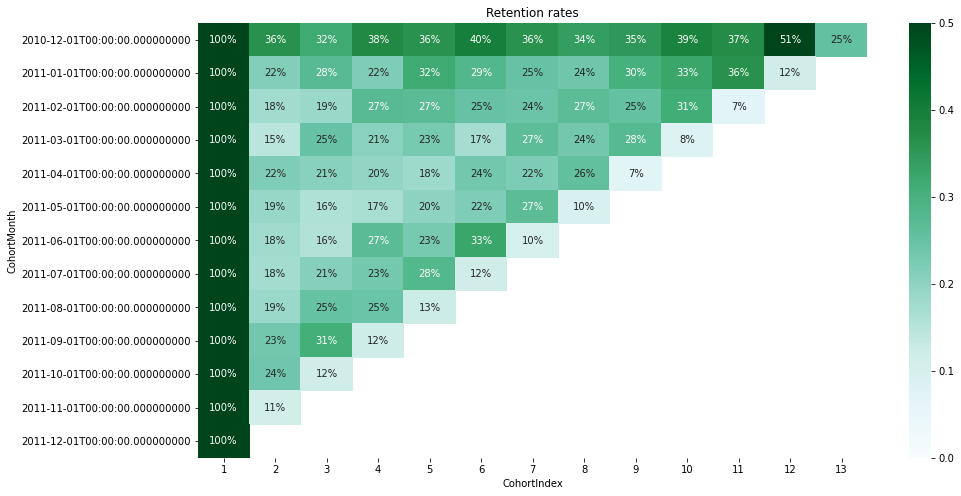

In [34]:
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data = retention,
annot = True,
fmt = '.0%',
vmin = 0.0,
vmax = 0.5,
cmap = 'BuGn')
plt.show()

In [35]:
snapshot_date = max(data.InvoiceDate) + dt.timedelta(days=1)

In [36]:
RFM_seg = data.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'Revenue': 'sum'})
# Rename the columns 
RFM_seg.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Revenue': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
print(RFM_seg.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12347.0           2        181        4060.40
12348.0          75         21        1186.68
12349.0          19         70        1353.80
12350.0         310         16         294.40
12352.0          36         77        1385.74


In [37]:
# Create labels for Recency and Frequency
r_labels = range(3, 0, -1) 
f_labels = range(1, 4)
r_groups = pd.qcut(RFM_seg['Recency'], q=3, labels=r_labels)
f_groups = pd.qcut(RFM_seg['Frequency'], q=3, labels=f_labels)
RFM_seg = RFM_seg.assign(R=r_groups.values, F=f_groups.values)

m_labels = range(1, 4)
m_groups = pd.qcut(RFM_seg['MonetaryValue'], q=3, labels=m_labels)
RFM_seg = RFM_seg.assign(M=m_groups.values)

# Calculate RFM_Score
RFM_seg['RFM_Score'] = RFM_seg[['R','F','M']].sum(axis=1)
print(RFM_seg['RFM_Score'].head())

CustomerID
12347.0    9
12348.0    6
12349.0    8
12350.0    3
12352.0    8
Name: RFM_Score, dtype: int64


In [38]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Best Customer'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9)):
        return 'Avg Customer'
    else:
        return 'Weak Customer'

# Create a new variable RFM_Level
RFM_seg['RFM_Level'] = RFM_seg.apply(rfm_level, axis=1)

# Print the header with top 5 rows to the console
print(RFM_seg.head(5))

            Recency  Frequency  MonetaryValue  R  F  M  RFM_Score  \
CustomerID                                                          
12347.0           2        181        4060.40  3  3  3          9   
12348.0          75         21        1186.68  2  1  3          6   
12349.0          19         70        1353.80  3  2  3          8   
12350.0         310         16         294.40  1  1  1          3   
12352.0          36         77        1385.74  2  3  3          8   

                RFM_Level  
CustomerID                 
12347.0     Best Customer  
12348.0      Avg Customer  
12349.0      Avg Customer  
12350.0     Weak Customer  
12352.0      Avg Customer  


In [39]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = RFM_seg.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

              Recency Frequency MonetaryValue      
                 mean      mean          mean count
RFM_Level                                          
Avg Customer     66.4      71.6        1109.7  2347
Best Customer     9.9     300.4        5195.8   663
Weak Customer   188.6      14.4         232.6  1207


In [40]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
RFM_seg['RFM_Segment'] = RFM_seg.apply(join_rfm, axis=1)
RFM_seg['RFM_Score'] = RFM_seg[['R','F','M']].sum(axis=1)
RFM_seg.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
333    663
111    646
233    347
222    330
211    293
122    276
322    226
311    158
112    147
121    121
dtype: int64

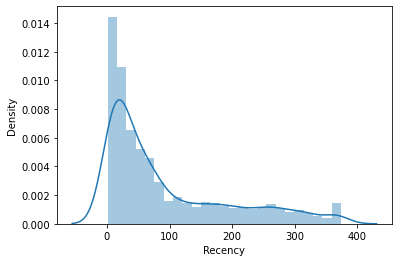

In [41]:
sns.distplot(RFM_seg['Recency'])
plt.show()

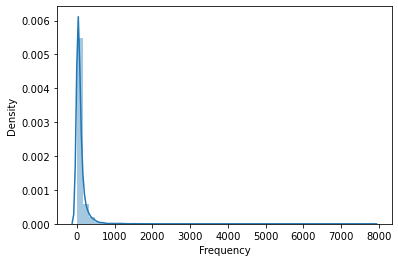

In [42]:
sns.distplot(RFM_seg['Frequency'])
plt.show()

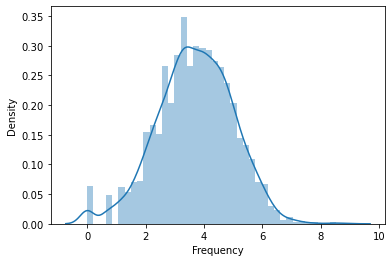

In [43]:
frequency_log= np.log(RFM_seg['Frequency'])
sns.distplot(frequency_log)
plt.show()

In [87]:
RFM_table = RFM_seg[['Recency','Frequency','MonetaryValue']]
RFM_table.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,2,181,4060.40
12348.0,75,21,1186.68
12349.0,19,70,1353.80
12350.0,310,16,294.40
12352.0,36,77,1385.74


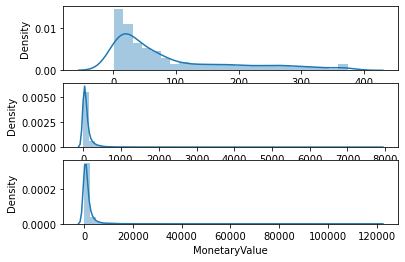

In [88]:
plt.subplot(3, 1, 1); sns.distplot(RFM_table['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_table['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_table['MonetaryValue'])
plt.show()

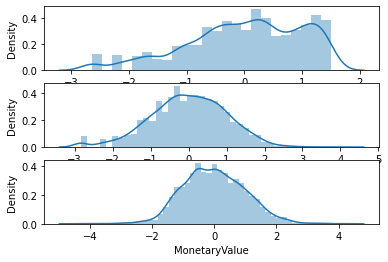

In [89]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x
# apply the function to Recency and MonetaryValue column 
RFM_table['Recency'] = [neg_to_zero(x) for x in RFM_table.Recency]
RFM_table['MonetaryValue'] = [neg_to_zero(x) for x in RFM_table.MonetaryValue]

# Unskew the data
RFM_log = np.log(RFM_table)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(RFM_log)

# Scale and center the data
RFM_normalized = scaler.transform(RFM_log)

# Create a pandas DataFrame
RFM_normalized = pd.DataFrame(data=RFM_normalized, index=RFM_table.index, columns=RFM_table.columns)

plt.subplot(3, 1, 1); sns.distplot(RFM_normalized['Recency'])
plt.subplot(3, 1, 2); sns.distplot(RFM_normalized['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(RFM_normalized['MonetaryValue'])
plt.show()

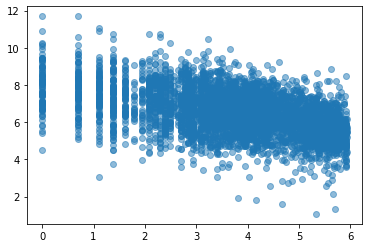

In [90]:
plt.scatter(RFM_log['Recency'], RFM_log['MonetaryValue'], alpha=0.5)

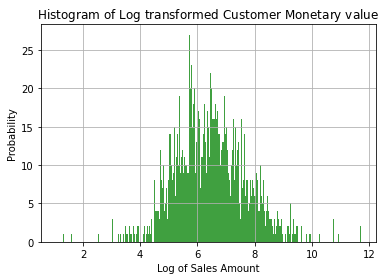

In [91]:
x = RFM_log['MonetaryValue']
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)

plt.xlabel('Log of Sales Amount')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Log\ transformed\ Customer\ Monetary\ value}\ $')
plt.grid(True)
plt.show()

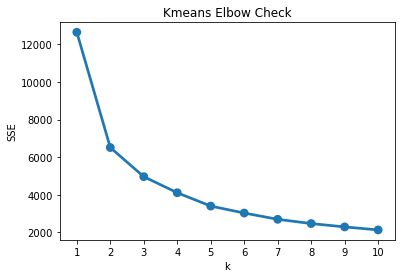

In [92]:
sse={}
# Fit KMeans and calculate SSE for each k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(RFM_normalized)
    sse[k] = kmeans.inertia_
    
plt.title('Kmeans Elbow Check')
plt.xlabel('k')
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

             Recency  Frequency  MonetaryValue
CustomerID                                    
12347.0    -2.153745   1.156956       1.487970
12348.0     0.383376  -0.497693       0.485944
12349.0    -0.577789   0.427180       0.593269
12350.0     1.376768  -0.706588      -0.649552
12352.0    -0.130419   0.500396       0.612264


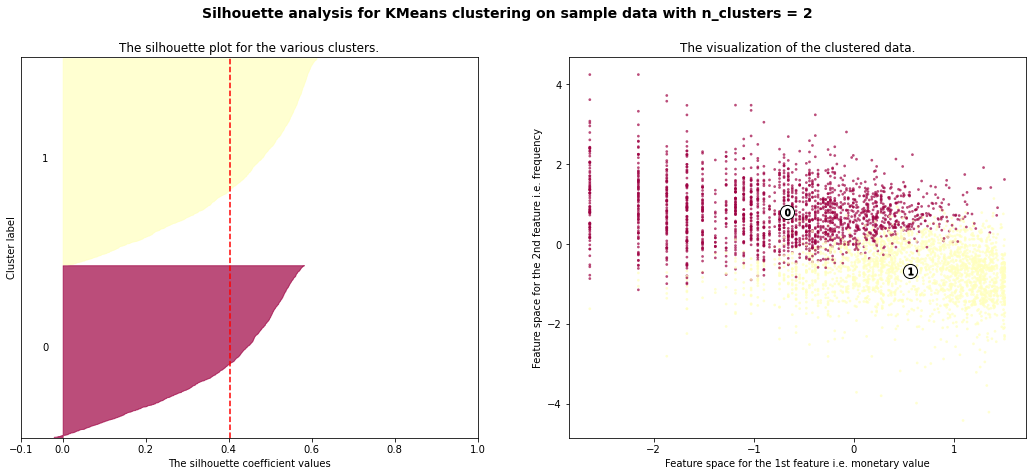

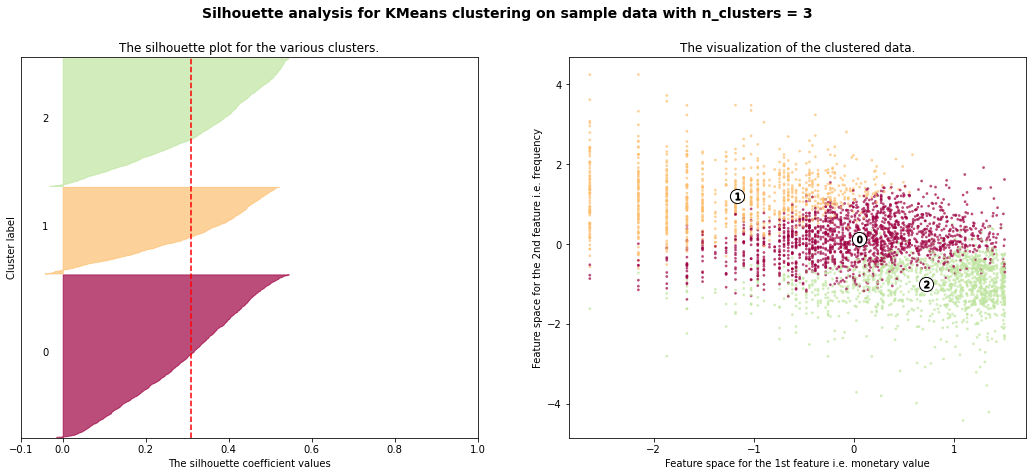

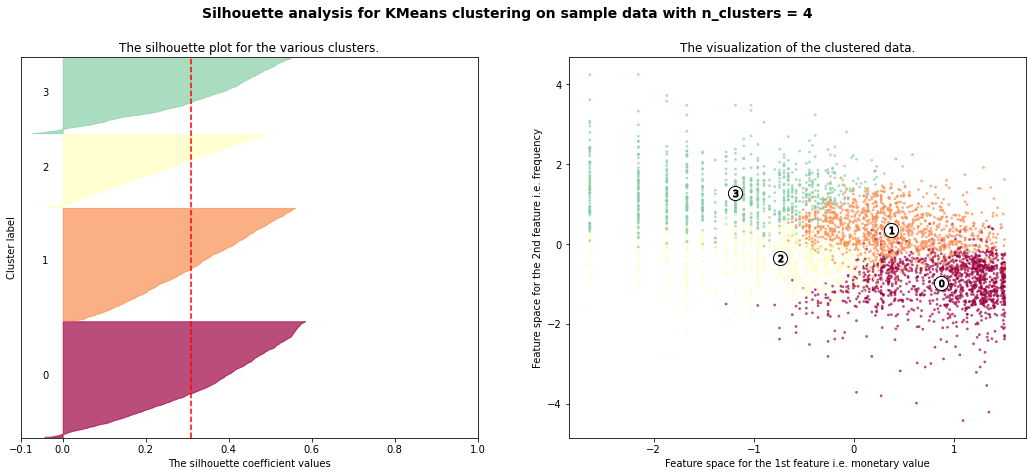

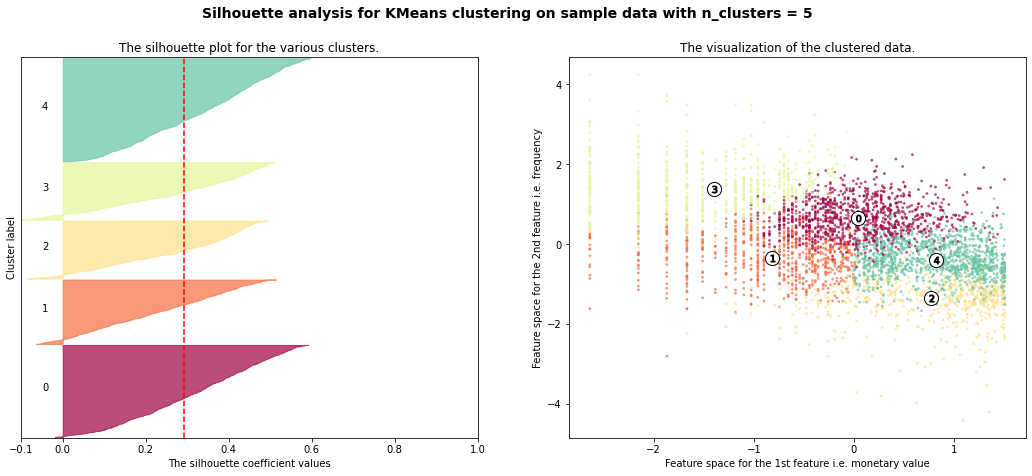

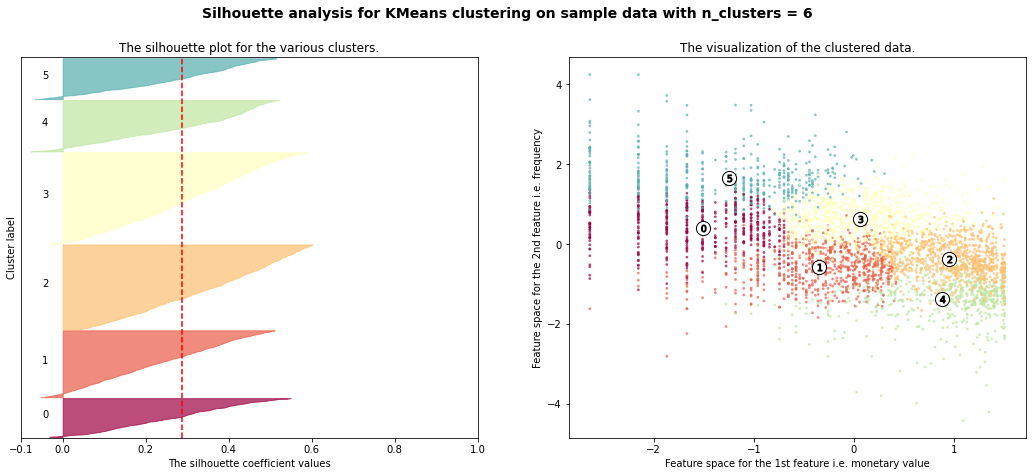

In [93]:
avg_silhouette_scores = []
X = RFM_normalized
cluster_centers = dict()
Krange = list(range(2,7))
print(X.head())

for n_clusters in Krange:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #ax2 = plt.subplot(111, projection='3d')
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':clusterer.cluster_centers_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X.iloc[:, feature1], X.iloc[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
    ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()


Text(0, 0.5, 'Average Silhouette Score')

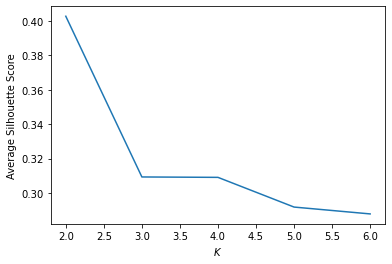

In [94]:
# Computing the avrage silhouette score for each K and plotting it 
# Call plot() with parameters KRange, avg_silhouette_scores
plt.plot(Krange, avg_silhouette_scores)
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score")

In [95]:
kmeans = KMeans(n_clusters=3, random_state=1) 
kmeans.fit(RFM_normalized)
cluster_labels = kmeans.labels_
# Create a DataFrame by adding a new cluster label column
RFM_k3 = RFM_table.assign(Cluster=cluster_labels)
grouped = RFM_k3.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          72.5      63.5         948.3  1819
1          14.1     256.4        4399.8   969
2         171.1      14.4         239.1  1429

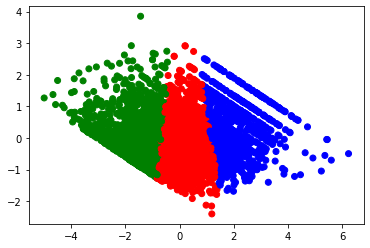

In [96]:
# Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans 
model = sklearn.cluster.KMeans(n_clusters=3)
# Call a fit_predict() on X 
cluster_assignments = model.fit_predict(X)

# Let's visualiaze with colors.ListedColormap
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

# We're going to do some PCA here. Call decomposition.PCA on sklearn, and pass n_components=2 as parameter
pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)

In [102]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

ap = AffinityPropagation().fit_predict(X)
ap_score=silhouette_score(X, ap)
print('Affinity Propagation score: %.2f' % ap_score)

sc = SpectralClustering().fit_predict(X)
sc_score=silhouette_score(X, sc)
print('Spectral Clustering score: %.2f' % sc_score)

ac = AgglomerativeClustering().fit_predict(X)
ac_score = silhouette_score(X, ac)
print('Agglomerative Clustering score: %.2f' % ac_score)

db = DBSCAN(min_samples=1).fit_predict(X)
db_score = silhouette_score(X, db)
print('DBSCAN score: %.2f' % db_score)

Affinity Propagation score: 0.23
Spectral Clustering score: 0.21
Agglomerative Clustering score: 0.39
DBSCAN score: -0.00


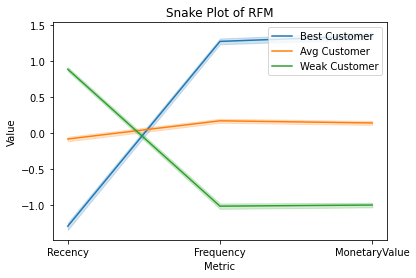

In [64]:
RFM_normalized = pd.DataFrame(RFM_normalized,
                                   index=RFM_table.index,
                                   columns=RFM_table.columns)
RFM_normalized['Cluster'] = RFM_k3['Cluster']
RFM_normalized['RFM_Level'] = RFM_seg['RFM_Level']
# Melt the normalized dataset and reset the index
RFM_melt = pd.melt(
    RFM_normalized.reset_index(),
    id_vars=['CustomerID', 'Cluster', 'RFM_Level'],
    value_vars=['Recency', 'Frequency', 'MonetaryValue'],
    var_name='Metric', value_name='Value')

# a snake plot with RFM
sns.lineplot(x = 'Metric', y = 'Value', hue = 'RFM_Level', data = RFM_melt)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

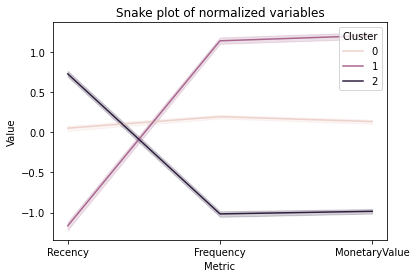

In [65]:
plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data=RFM_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

In [ ]:
# Calculate average RFM values for each cluster
cluster_avg = RFM_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = RFM_table.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

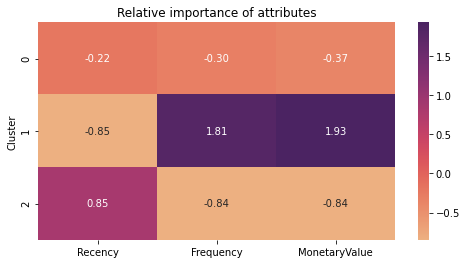

In [73]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 4))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='flare')
plt.show()

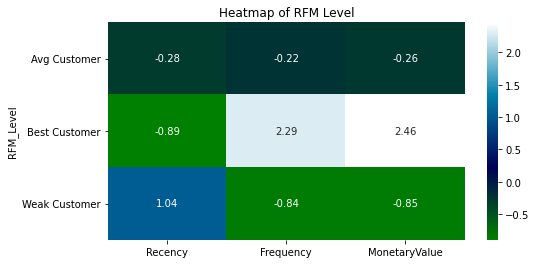

In [85]:
# Calculate average RFM values for each cluster
RFM_Level_avg = RFM_seg.groupby(['RFM_Level']).mean().iloc[:, 0:3]

# Calculate average RFM values for the total customer population
population_avg = RFM_table.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp_RFM_Level = RFM_Level_avg / population_avg - 1

# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 4))

# Add the plot title
plt.title('Heatmap of RFM Level')

# Plot the heatmap
sns.heatmap(data=relative_imp_RFM_Level, annot=True, fmt='.2f', cmap='ocean')
plt.show()